# Decision Trees    

The dataset used here is that of Drug prediction based on the health parameters of a patient.


### Import Libraries

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### About the dataset
Scenario:

You are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug C, Drug X and Drug Y. 

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are the Age, Sex, Blood Pressure, and Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of a multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of an unknown patient or to prescribe a drug to a new patient.


<div id="downloading_data"> 
   We download the data from IBM Object Storage.
</div>


In [2]:
path= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
my_data = pd.read_csv(path)
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Data Analysis and pre-processing

In [3]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


This tells us that 4 out of the 6 features of this dataset are categorical, which will have to be converted into numerical ones to be used for modeling. For this, we use __LabelEncoder__ from the Scikit-Learn library.


In [4]:
label_encoder = LabelEncoder()
my_data['Sex'] = label_encoder.fit_transform(my_data['Sex']) 
my_data['BP'] = label_encoder.fit_transform(my_data['BP'])
my_data['Cholesterol'] = label_encoder.fit_transform(my_data['Cholesterol']) 
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


With this, you now have 5 parameters that can be used for modeling and 1 feature as the target variable. 
We can see from comparison of the data before Label encoding and after it, to note the following mapping.
<br>
For parameter 'Sex' : $M \rightarrow 1, F \rightarrow 0$ <br>
For parameter 'BP' : $High \rightarrow 0, Low \rightarrow 1, Normal \rightarrow 2$<br>
For parameter 'Cholesterol' : $High \rightarrow 0, Normal \rightarrow 1$


In [5]:
# Check for missing values:

my_data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

To evaluate the correlation of the target variable with the input features, it will be convenient to map the different drugs to a numerical value. Execute the following cell to achieve the same.


In [6]:
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}
my_data['Drug_num'] = my_data['Drug'].map(custom_map)
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


We find the correlation of the input variables with the target variable.

We find the correlation of the input variables with the target variable and identify the features most significantly affecting the target.


In [9]:
my_data.drop('Drug',axis=1).corr()['Drug_num']

Age           -0.004828
Sex           -0.098573
BP             0.372868
Cholesterol    0.055629
Na_to_K        0.589120
Drug_num       1.000000
Name: Drug_num, dtype: float64

Plot the count of the records with each drug recommendation. 


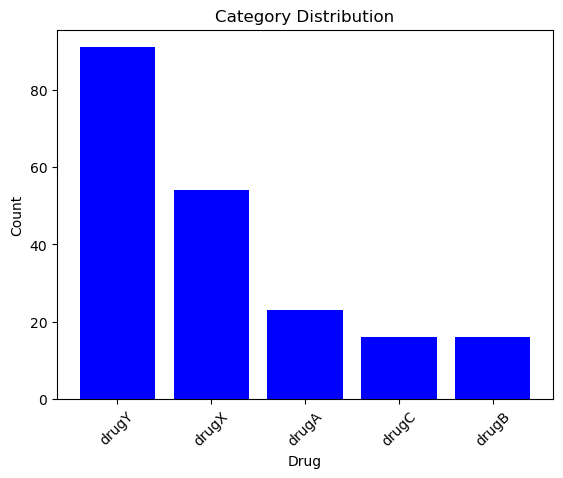

In [10]:
category_counts = my_data['Drug'].value_counts()

# Plot the count plot
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

## Modeling


For modeling this dataset with a Decision tree classifier, we first split the dataset into training and testing subsets. For this, we separate the target variable from the input variables.


In [11]:
y = my_data['Drug']
X = my_data.drop(['Drug','Drug_num'], axis=1)

We separate the training data from the testing data. We can make use of 30% of the data for testing and the rest for training the Decision tree.


In [12]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)

We define the Decision tree classifier as __drugTree__ and train it with the training data. 


In [13]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [14]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Evaluation


Now that we have trained the decision tree, we can use it to generate the predictions on the test set.


In [15]:
tree_predictions = drugTree.predict(X_testset)

We can now check the accuracy of our model by using the accuracy metric.


In [16]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.9833333333333333


This means that the model was able to correctly identify the labels of 98.33%, i.e. 59 out of 60 test samples. 


### Visualize the tree

To understand the classification criteria derived by the Decision Tree, we generate the tree plot.


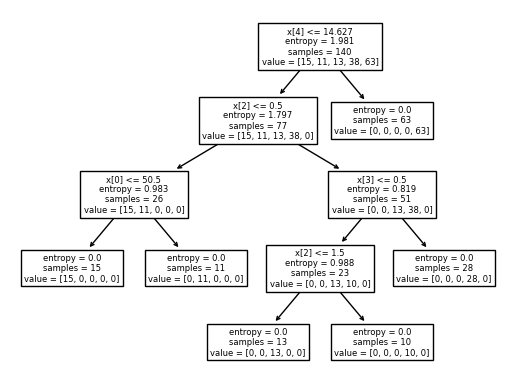

In [17]:
plot_tree(drugTree)
plt.show()

From this tree, we can derive the criteria developed by the model to identify the class of each training sample. We can interpret them by tracing the criteria defined by tracing down from the root to the tree's leaf nodes.

For instance, the decision criterion for Drug Y is ${Na\_to\_K} \gt 14.627$.

The decision criteria for all other classes are:

Drug A : $Na\_to\_K <= 14.627, BP = High, Age <= 50.5$<br>
Drug B : $Na\_to\_K <= 14.627, BP = High, Age > 50.5$ <br>
Drug C : $Na\_to\_K <= 14.627, BP = Normal, Cholesterol = High$<br>
Drug X : $Na\_to\_K <= 14.627, (BP = Low, Cholesterol = High) or (BP = Normal/Low, Cholesterol = Normal)$


If the max depth of the tree is reduced to 3, the performance of the model would be:

In [18]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
drugTree.fit(X_trainset,y_trainset)
tree_predictions = drugTree.predict(X_testset)
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.8166666666666667
